In [1]:
import os
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as ticker
# PyTorch
import torch
# GPyTorch
from gpytorch.mlls import ExactMarginalLogLikelihood
# BOTorch
import botorch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf

/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_job(
    alpha, beta, criterion, dataset, dataset_directory, experiments_directory, 
    lr_0, model_arch, n, prior_directory, prior_type, random_state, save, tune
):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
        n_train = n - int((1/5) * n) if tune else n
        if check_epochs(temp_df, n_train, batch_size=min(128, n_train), steps=6000):
            return

    command = (
        f"python ../src/main_{dataset}.py "
        f"--alpha={alpha} "
        f"--beta={beta} "
        "--batch_size=128 "
        f"--criterion='{criterion}' "
        f"--dataset_directory='{dataset_directory}' "
        f"--experiments_directory='{experiments_directory}' "
        f"--lr_0={lr_0} "
        f"--model_arch='{model_arch}' "
        f"--model_name='{model_name}' "
        f"--n={n} "
        "--num_workers=0 "
        f"--prior_directory='{prior_directory}' "
        f"--prior_type='{prior_type}' "
        f"--random_state={random_state} "
        f"{'--save' if save else ''}"
        f"{'--tune' if tune else ''}"
    )
    
    print(f'    "{command}"')
    
def check_epochs(df, n, batch_size=128, steps=6000):
    num_batches = math.floor(n/batch_size)
    epochs = int(steps/num_batches)
    return True if df.shape[0] == epochs else False

def get_runtime(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 0.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000):
        return 0.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['train_sec/epoch'].sum()

def get_val_or_test_acc(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 0.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000):
        return 0.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['val_or_test_acc'].values[-1]
    
def get_val_or_test_nll(alpha, beta, criterion, experiments_directory, lr_0, n, random_state, tune):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    if not os.path.exists(f'{experiments_directory}/{model_name}.csv'):
        return 10.0
        #raise FileNotFoundError(f'Expected file not found: {experiments_directory}/{model_name}.csv')
    df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    n_train = n - int((1/5) * n) if tune else n
    if not check_epochs(df, n_train, batch_size=min(128, n_train), steps=6000):
        return 10.0
        #raise RuntimeError(f'Run incomplete: {model_name} did not run for the specified number of epochs')
    return df['val_or_test_nll'].values[-1]

def get_candidate(train_X, train_Y, seed):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    gp = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        input_transform=Normalize(d=3),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    logEI = LogExpectedImprovement(model=gp, best_f=train_Y.max())

    bounds = torch.stack([torch.zeros(3), torch.ones(3)]).to(torch.double)
    candidate, acq_value = optimize_acqf(
      logEI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    
    return candidate.detach()

In [3]:
# DONE:

# CIFAR-10 n_iters = 26, 27, 28, 29, 30, 31, 32, 33, 34, 35 retrained
# Pets-37 n_iters = 26, 27, 28, 29, 30, 31, 32, 33, 34, 35 retrained
# Flowers-102 n_iters = 26, 27, 28, 29, 30, 31, 32, 33, 34, 35 retrained

# CIFAR-10 n_iters = 35 tuned
# Pets-37 n_iters = 35 tuned
# Flowers-102 n_iters = 35 tuned

# CIFAR-10 n_iters = 36 tuned
# Pets-37 n_iters = 36 tuned
# Flowers-102 n_iters = 36 tuned

# CIFAR-10 n_iters = 37 tuned
# Pets-37 n_iters = 37 tuned
# Flowers-102 n_iters = 37 tuned

# TODO:

# CIFAR-10 n_iters = 38 tuned
# Pets-37 n_iters = 38 tuned
# Flowers-102 n_iters = 38 tuned


In [4]:
criterion = 'l2-sp'
dataset = 'CIFAR-10'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
model_arch = 'ConvNeXt_Tiny'
ns = [100, 1000, 10000, 50000]
n_iters = 35
prior_directory = '/cluster/tufts/hugheslab/eharve06/convnext_tiny_torchvision'
prior_type = 'convnext_tiny_torchvision'
random_states = [1001, 2001, 3001]
retrained_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_BO_ConvNeXt_Tiny'
tuned_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_BO_ConvNeXt_Tiny'
seeds = [0, 1, 2, 3, 4]

bounds = torch.tensor([[-6, -6, -4], [-2, -2, -1]], dtype=torch.double)

columns = ['alpha', 'beta', 'lr_0', 'n', 'n_iter', 'random_state', 'runtime', 'seed', 'val_acc', 'val_nll', 'test_acc', 'test_nll']
cifar10_bo_df = pd.DataFrame(columns=columns)

for n, random_state, seed in itertools.product(ns, random_states, seeds):

    gen = torch.Generator()
    gen.manual_seed(seed)

    train_X = torch.rand(size=(1, 3,), generator=gen, dtype=torch.double)
    train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
    
    alpha, beta, lr_0 = 10**train_X_bounded[0]
    print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

    train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)
    
    alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
    print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
    
    runtime = 0.0
    runtime = get_runtime(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    
    val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

    row = [alpha.item(), beta.item(), lr_0.item(), n, 0, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
    cifar10_bo_df.loc[len(cifar10_bo_df)] = row
    
    for i in range(1, n_iters+1):

        candidate = get_candidate(train_X, train_Y, seed)
        candidate_bounded = (bounds[1]-bounds[0]) * candidate + bounds[0]
        train_X = torch.cat([train_X, candidate])
        train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
                
        alpha, beta, lr_0 = 10**candidate_bounded[0]
        print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

        train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)

        alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
        #print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
        
        runtime = 0.0
        runtime = sum([get_runtime(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True) for x in train_X_bounded])
        runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        
        val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        row = [alpha.item(), beta.item(), lr_0.item(), n, i, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
        cifar10_bo_df.loc[len(cifar10_bo_df)] = row

cifar10_bo_df.head(100)

/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/botorch/optim/optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


,alpha,beta,lr_0,n,n_iter,random_state,runtime,seed,val_acc,val_nll,test_acc,test_nll
0,0.007589,0.000678,0.002389,100.0,0.0,1001.0,6941.181364,0.0,0.60,1.291354,0.6895,1.007312
1,0.000001,0.000001,0.100000,100.0,1.0,1001.0,9627.154016,0.0,0.40,3.193286,0.6895,1.007312
2,0.004565,0.001518,0.000627,100.0,2.0,1001.0,12253.339415,0.0,0.70,1.114461,0.6500,1.101206
3,0.000287,0.010000,0.002248,100.0,3.0,1001.0,14865.472126,0.0,0.60,1.209142,0.6500,1.101206
4,0.010000,0.010000,0.000100,100.0,4.0,1001.0,17441.893066,0.0,0.65,1.216636,0.6500,1.101206
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000187,0.000001,0.000223,100.0,23.0,1001.0,67689.889091,2.0,0.75,1.029704,0.8047,0.775284
96,0.000006,0.000001,0.000445,100.0,24.0,1001.0,70440.697596,2.0,0.75,1.008025,0.8047,0.775284
97,0.000281,0.000030,0.045352,100.0,25.0,1001.0,73163.069124,2.0,0.80,0.691157,0.8047,0.775284
98,0.000088,0.000769,0.000430,100.0,26.0,1001.0,75813.926749,2.0,0.70,1.009623,0.8047,0.775284


In [5]:
cifar10_bo_grouped_df = cifar10_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    cifar10_bo_grouped_df[f'{column}_mean'] = cifar10_bo_grouped_df[column].apply(lambda item: np.mean(item))
    cifar10_bo_grouped_df[f'{column}_std'] = cifar10_bo_grouped_df[column].apply(lambda item: np.std(item))
    cifar10_bo_grouped_df[f'{column}_min'] = cifar10_bo_grouped_df[column].apply(lambda item: np.min(item))
    cifar10_bo_grouped_df[f'{column}_max'] = cifar10_bo_grouped_df[column].apply(lambda item: np.max(item))
cifar10_bo_grouped_df = cifar10_bo_grouped_df.reset_index()
cifar10_bo_grouped_df

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,100.0,0.0,1001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(6941.181363582611, 6241.474300146103, 6164.70...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.6000000834465027, 0.7500001192092896, 0.650...","(1.2913535833358765, 1.03718364238739, 0.92717...",...,5864.111956,6941.181364,0.65000,0.054772,0.6000,0.7500,0.70832,0.081145,0.6080,0.8095
1,100.0,0.0,2001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(5831.208561420441, 5869.264914035797, 5852.55...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.5, 0.4500000476837158, 0.6000000238418579, ...","(2.120349168777466, 1.9108734130859373, 1.6693...",...,5831.208561,5869.264914,0.53000,0.050990,0.4500,0.6000,0.73098,0.067555,0.6548,0.8151
2,100.0,0.0,3001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(5795.697523593903, 5845.676057815552, 5973.08...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7500000596046448, 0.7000000476837158, 0.800...","(0.8124095797538757, 0.8094868659973145, 0.338...",...,5795.697524,6167.409505,0.77000,0.050990,0.7000,0.8500,0.76594,0.044268,0.7173,0.8176
3,100.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(9627.154016256332, 9107.608215808868, 8834.28...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.4000000059604645, 0.7500001192092896, 0.650...","(3.1932857036590576, 0.9973223805427552, 1.216...",...,8473.141821,9627.154016,0.62000,0.116619,0.4000,0.7500,0.73122,0.074365,0.6080,0.8095
4,100.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(8437.144790887833, 8504.659116268158, 8791.42...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.550000011920929, 0.6000000238418579, 0.5500...","(3.493883848190308, 2.375278949737549, 1.45739...",...,8437.144791,9772.025777,0.59000,0.058310,0.5500,0.7000,0.66670,0.022333,0.6500,0.7090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,50000.0,34.0,2001.0,"(0.01, 0.01, 0.01, 0.01, 0.01)","(0.01, 0.01, 1e-06, 0.01, 0.01)","(0.0809494922653, 0.1, 0.004975559975002562, 0...","(145127.45690345764, 144625.49839687347, 14613...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9808000326156616, 0.979699969291687, 0.9760...","(0.0586140546619892, 0.0592855300016701, 0.072...",...,144625.498397,149061.458031,0.97938,0.001754,0.9760,0.9808,0.97872,0.000204,0.9785,0.9791
428,50000.0,34.0,3001.0,"(0.01, 3.519485040443127e-05, 0.01, 0.01, 0.01)","(0.01, 0.00032240028737910584, 0.01, 0.01, 0.01)","(0.023972211832841844, 0.007058756853084184, 0...","(147075.26141500473, 146677.68187713623, 14804...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.980299949645996, 0.980400025844574, 0.98040...","(0.0629743080284446, 0.0653822380580008, 0.062...",...,146677.681877,149282.063379,0.98038,0.000382,0.9798,0.9810,0.97910,0.000514,0.9782,0.9796
429,50000.0,35.0,1001.0,"(0.01, 0.01, 0.01, 0.01, 0.01)","(0.01, 0.01, 0.01, 1e-06, 2.0113204181806678e-05)","(0.025645190384762002, 0.004957684451004989, 0...","(151649.48632073402, 150090.9954931736, 149518...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9803999662399292, 0.977500021457672, 0.9790...","(0.0601899828881025, 0.0687753569737076, 0.060...",...,149402.584868,151649.486321,0.97866,0.001208,0.9771,0.9804,0.97976,0.000445,0.9789,0.9802
430,50000.0,35.0,2001.0,"(0.01, 0.01, 1e-06, 0.01, 0.01)","(0.01, 0.01, 0.01, 0.01, 0.01)","(0.08138543475560545, 0.1, 0.01207914720479370...","(149236.82378864

In [6]:
criterion = 'l2-sp'
dataset = 'Oxford-IIIT_Pet'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/Oxford-IIIT_Pet'
model_arch = 'ConvNeXt_Tiny'
ns = [370, 3441]
n_iters = 35
prior_directory = '/cluster/tufts/hugheslab/eharve06/convnext_tiny_torchvision'
prior_type = 'convnext_tiny_torchvision'
random_states = [1001, 2001, 3001]
retrained_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_BO_ConvNeXt_Tiny'
tuned_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_Oxford-IIIT_Pet_BO_ConvNeXt_Tiny'
seeds = [0, 1, 2, 3, 4]

bounds = torch.tensor([[-6, -6, -4], [-2, -2, -1]], dtype=torch.double)

columns = ['alpha', 'beta', 'lr_0', 'n', 'n_iter', 'random_state', 'runtime', 'seed', 'val_acc', 'val_nll', 'test_acc', 'test_nll']
pet37_bo_df = pd.DataFrame(columns=columns)

for n, random_state, seed in itertools.product(ns, random_states, seeds):

    gen = torch.Generator()
    gen.manual_seed(seed)

    train_X = torch.rand(size=(1, 3,), generator=gen, dtype=torch.double)
    train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
    
    alpha, beta, lr_0 = 10**train_X_bounded[0]
    print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

    train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)
    
    alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
    print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
    
    runtime = 0.0
    runtime = get_runtime(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    
    val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

    row = [alpha.item(), beta.item(), lr_0.item(), n, 0, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
    pet37_bo_df.loc[len(pet37_bo_df)] = row
    
    for i in range(1, n_iters+1):

        candidate = get_candidate(train_X, train_Y, seed)
        candidate_bounded = (bounds[1]-bounds[0]) * candidate + bounds[0]
        train_X = torch.cat([train_X, candidate])
        train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
        
        alpha, beta, lr_0 = 10**candidate_bounded[0]
        print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

        train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)

        alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
        #print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
        
        runtime = 0.0
        runtime = sum([get_runtime(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True) for x in train_X_bounded])
        runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        
        val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        row = [alpha.item(), beta.item(), lr_0.item(), n, i, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
        pet37_bo_df.loc[len(pet37_bo_df)] = row

pet37_bo_df.head(100)

,alpha,beta,lr_0,n,n_iter,random_state,runtime,seed,val_acc,val_nll,test_acc,test_nll
0,0.007589,0.000678,0.002389,370.0,0.0,1001.0,7622.572840,0.0,0.932432,0.165683,0.882930,0.401487
1,0.000001,0.000001,0.100000,370.0,1.0,1001.0,11848.482882,0.0,0.891892,0.271046,0.882930,0.401487
2,0.002364,0.001456,0.000670,370.0,2.0,1001.0,15563.387040,0.0,0.959459,0.208767,0.882930,0.401487
3,0.010000,0.000337,0.008134,370.0,3.0,1001.0,19318.812913,0.0,0.959459,0.161634,0.892498,0.366005
4,0.010000,0.000031,0.000408,370.0,4.0,1001.0,23596.698935,0.0,0.972973,0.285752,0.892498,0.366005
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000001,0.000026,0.002887,370.0,23.0,1001.0,95031.721633,2.0,0.932432,0.155863,0.898210,0.345382
96,0.010000,0.000021,0.003342,370.0,24.0,1001.0,98789.311465,2.0,0.945946,0.163098,0.898210,0.345382
97,0.000001,0.010000,0.001780,370.0,25.0,1001.0,102577.886484,2.0,0.945946,0.227530,0.898210,0.345382
98,0.010000,0.000031,0.021537,370.0,26.0,1001.0,106197.095139,2.0,0.945946,0.149829,0.898210,0.345382


In [7]:
pet37_bo_grouped_df = pet37_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    pet37_bo_grouped_df[f'{column}_mean'] = pet37_bo_grouped_df[column].apply(lambda item: np.mean(item))
    pet37_bo_grouped_df[f'{column}_std'] = pet37_bo_grouped_df[column].apply(lambda item: np.std(item))
    pet37_bo_grouped_df[f'{column}_min'] = pet37_bo_grouped_df[column].apply(lambda item: np.min(item))
    pet37_bo_grouped_df[f'{column}_max'] = pet37_bo_grouped_df[column].apply(lambda item: np.max(item))
pet37_bo_grouped_df = pet37_bo_grouped_df.reset_index()
pet37_bo_grouped_df

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,370.0,0.0,1001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7622.572840213776, 7122.802211046219, 7158.62...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9324324727058412, 0.9594594836235046, 0.959...","(0.1656830459833145, 0.2356095165014267, 0.153...",...,7122.802211,7622.572840,0.932432,0.025640,0.891892,0.959459,0.874552,0.020319,0.842854,0.896920
1,370.0,0.0,2001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7721.646580457687, 7801.981445074081, 7882.98...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9459459781646729, 0.8918918967247009, 0.932...","(0.2301973104476928, 0.3530605733394623, 0.188...",...,7222.425373,7882.985600,0.908108,0.046342,0.824324,0.945946,0.870448,0.018782,0.835356,0.887275
2,370.0,0.0,3001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7811.3101053237915, 7195.052761554718, 7175.6...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8783783912658691, 0.8378378748893738, 0.878...","(0.3388819694519043, 0.4188233613967895, 0.291...",...,7146.802203,7811.310105,0.856757,0.018331,0.837838,0.878378,0.885523,0.023112,0.843518,0.905073
3,370.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(11848.482882261276, 11386.544362783432, 11434...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8918919563293457, 0.8648648858070374, 0.864...","(0.2710461020469665, 0.5444959402084351, 1.453...",...,10827.781043,11848.482882,0.881081,0.021622,0.864865,0.918919,0.887760,0.016533,0.859398,0.908895
4,370.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(10850.8718791008, 11410.697837591171, 11602.5...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9054054617881776, 0.8918918967247009, 0.797...","(0.2215731143951416, 0.4245591163635254, 1.704...",...,10850.871879,11602.595199,0.870270,0.063729,0.797297,0.959459,0.879771,0.010172,0.867378,0.891796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,3441.0,34.0,2001.0,"(0.01, 0.01, 1e-06, 0.01, 0.01)","(1e-06, 1e-06, 0.01, 1.1694982075612966e-05, 1...","(0.0014150960749173215, 0.018620856602256434, ...","(129292.75915527344, 127017.31152939796, 12731...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9429587125778198, 0.9661450386047364, 0.942...","(0.1475874649923901, 0.1065425642354543, 0.145...",...,126331.959623,129292.759155,0.956510,0.011260,0.942508,0.966145,0.942731,0.000486,0.942047,0.943369
212,3441.0,34.0,3001.0,"(0.01, 0.01, 0.01, 8.377612400439577e-05, 0.00...","(1e-06, 0.01, 1e-06, 3.256647065839174e-06, 0.01)","(0.031895549113379267, 0.0754881060817351, 0.0...","(126934.44026017189, 126200.73592233658, 12817...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.970199167728424, 0.967496395111084, 0.95398...","(0.1043856202862983, 0.1398232444081195, 0.143...",...,126124.171781,128176.461321,0.929758,0.066930,0.796373,0.970199,0.943176,0.000666,0.942058,0.943961
213,3441.0,35.0,1001.0,"(0.01, 0.01, 1e-06, 0.01, 6.878998101801657e-05)","(2.2707571810797816e-05, 1e-06, 0.01, 6.096249...","(0.09000407032839687, 0.04701408839662381, 0.0...","(129680.7735645771, 129395.03008890152, 133083...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9518017768859864, 0.96126127243042, 0.94836...","(0.1473469777509223, 0.1316300478092459, 0.150...",...,129395.030089,133083.416181,0.951702,0.009445,0.935823,0.961261,0.942549,0.000748,0.941615,0.943841
214,3441.0,35.0,2001.0,"(0.01, 0.01, 0.

In [8]:
criterion = 'l2-sp'
dataset = 'Flowers_102'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/Flowers_102'
model_arch = 'ConvNeXt_Tiny'
ns = [510, 1020]
n_iters = 35
prior_directory = '/cluster/tufts/hugheslab/eharve06/convnext_tiny_torchvision'
prior_type = 'convnext_tiny_torchvision'
random_states = [1001, 2001, 3001]
retrained_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_BO_ConvNeXt_Tiny'
tuned_experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_Flowers_102_BO_ConvNeXt_Tiny'
seeds = [0, 1, 2, 3, 4]

bounds = torch.tensor([[-6, -6, -4], [-2, -2, -1]], dtype=torch.double)

columns = ['alpha', 'beta', 'lr_0', 'n', 'n_iter', 'random_state', 'runtime', 'seed', 'val_acc', 'val_nll', 'test_acc', 'test_nll']
flower102_bo_df = pd.DataFrame(columns=columns)

for n, random_state, seed in itertools.product(ns, random_states, seeds):

    gen = torch.Generator()
    gen.manual_seed(seed)

    train_X = torch.rand(size=(1, 3,), generator=gen, dtype=torch.double)
    train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
    
    alpha, beta, lr_0 = 10**train_X_bounded[0]
    print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

    train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)
    
    alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
    print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
    
    runtime = 0.0
    runtime = get_runtime(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    
    val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
    test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
    test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

    row = [alpha.item(), beta.item(), lr_0.item(), n, 0, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
    flower102_bo_df.loc[len(flower102_bo_df)] = row
    
    for i in range(1, n_iters+1):

        candidate = get_candidate(train_X, train_Y, seed)
        candidate_bounded = (bounds[1]-bounds[0]) * candidate + bounds[0]
        train_X = torch.cat([train_X, candidate])
        train_X_bounded = (bounds[1]-bounds[0]) * train_X + bounds[0]
        
        alpha, beta, lr_0 = 10**candidate_bounded[0]
        print_job(alpha, beta, criterion, dataset, dataset_directory, tuned_experiments_directory, lr_0, model_arch, n, prior_directory, prior_type, random_state, False, True)

        train_Y = torch.tensor([[-get_val_or_test_nll(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True)] for x in train_X_bounded], dtype=torch.float64)

        alpha_star, beta_star, lr_0_star = 10**train_X_bounded[torch.argmax(train_Y)]
        #print_job(alpha_star, beta_star, criterion, dataset, dataset_directory, retrained_experiments_directory, lr_0_star, model_arch, n, prior_directory, prior_type, random_state, True, False)
        
        runtime = 0.0
        runtime = sum([get_runtime(10**x[0], 10**x[1], criterion, tuned_experiments_directory, 10**x[2], n, random_state, True) for x in train_X_bounded])
        runtime += get_runtime(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        
        val_acc = get_val_or_test_acc(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        val_nll = get_val_or_test_nll(alpha, beta, criterion, tuned_experiments_directory, lr_0, n, random_state, True)
        test_acc = get_val_or_test_acc(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)
        test_nll = get_val_or_test_nll(alpha_star, beta_star, criterion, retrained_experiments_directory, lr_0_star, n, random_state, False)

        row = [alpha.item(), beta.item(), lr_0.item(), n, i, random_state, runtime, seed, val_acc, val_nll, test_acc, test_nll]
        flower102_bo_df.loc[len(flower102_bo_df)] = row

flower102_bo_df.head(100)

,alpha,beta,lr_0,n,n_iter,random_state,runtime,seed,val_acc,val_nll,test_acc,test_nll
0,0.007589,0.000678,0.002389,510.0,0.0,1001.0,7108.617203,0.0,0.794118,0.944847,0.832493,0.820326
1,0.000001,0.000001,0.100000,510.0,1.0,1001.0,10784.787583,0.0,0.666667,1.488824,0.832493,0.820326
2,0.003448,0.001479,0.000639,510.0,2.0,1001.0,14534.996344,0.0,0.764706,1.545155,0.832493,0.820326
3,0.010000,0.000513,0.003804,510.0,3.0,1001.0,18374.722632,0.0,0.813726,0.894170,0.849457,0.762403
4,0.010000,0.003177,0.004515,510.0,4.0,1001.0,22179.254153,0.0,0.813726,0.927907,0.849457,0.762403
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000018,0.000001,0.020334,510.0,23.0,1001.0,93540.990056,2.0,0.843137,0.668450,0.892671,0.518188
96,0.000001,0.000001,0.017856,510.0,24.0,1001.0,97861.830223,2.0,0.803922,0.711648,0.892671,0.518188
97,0.000040,0.000001,0.022994,510.0,25.0,1001.0,102166.745179,2.0,0.843137,0.625879,0.893234,0.514453
98,0.010000,0.000001,0.001238,510.0,26.0,1001.0,105892.779017,2.0,0.794118,1.124442,0.893234,0.514453


In [9]:
flower102_bo_grouped_df = flower102_bo_df.groupby(['n', 'n_iter', 'random_state']).agg(lambda x: tuple(x))
columns = ['runtime', 'val_acc', 'test_acc']
for column in columns:
    flower102_bo_grouped_df[f'{column}_mean'] = flower102_bo_grouped_df[column].apply(lambda item: np.mean(item))
    flower102_bo_grouped_df[f'{column}_std'] = flower102_bo_grouped_df[column].apply(lambda item: np.std(item))
    flower102_bo_grouped_df[f'{column}_min'] = flower102_bo_grouped_df[column].apply(lambda item: np.min(item))
    flower102_bo_grouped_df[f'{column}_max'] = flower102_bo_grouped_df[column].apply(lambda item: np.max(item))
flower102_bo_grouped_df = flower102_bo_grouped_df.reset_index()
flower102_bo_grouped_df

,n,n_iter,random_state,alpha,beta,lr_0,runtime,seed,val_acc,val_nll,...,runtime_min,runtime_max,val_acc_mean,val_acc_std,val_acc_min,val_acc_max,test_acc_mean,test_acc_std,test_acc_min,test_acc_max
0,510.0,0.0,1001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7108.617203474045, 7252.8706176280975, 7190.2...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7941176891326904, 0.7647058963775635, 0.774...","(0.9448467493057252, 1.78338623046875, 0.87129...",...,7108.617203,7252.870618,0.723529,0.138287,0.450980,0.833333,0.777771,0.136613,0.520541,0.895192
1,510.0,0.0,2001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7101.707026004791, 7129.543971776962, 9005.38...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.8431373238563538, 0.7450981140136719, 0.862...","(0.7512351274490356, 1.6562025547027588, 0.564...",...,7101.707026,9005.380013,0.752941,0.167575,0.431373,0.882353,0.793494,0.126499,0.549014,0.887579
2,510.0,0.0,3001.0,"(0.00758947976208385, 1.7547413041177135e-06, ...","(0.0006780776932355295, 7.91075667332751e-06, ...","(0.0023886297077207034, 0.0005043796336040412,...","(7157.395022392273, 7327.174964904785, 7718.32...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.774509847164154, 0.6666667461395264, 0.8235...","(1.0340112447738647, 2.055185556411743, 0.8645...",...,7157.395022,7795.830989,0.707843,0.156544,0.421569,0.852941,0.725269,0.171297,0.400670,0.857293
3,510.0,1.0,1001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(10784.78758263588, 11602.91801071167, 10902.1...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.6666666865348816, 0.6764706373214722, 0.343...","(1.4888240098953247, 1.610375165939331, 3.7572...",...,10784.787583,13100.098206,0.560784,0.181666,0.343137,0.774510,0.834107,0.051866,0.747789,0.895192
4,510.0,1.0,2001.0,"(1.1021585497520294e-06, 0.0034424767798646888...","(1e-06, 0.01, 0.008424264162555345, 0.01, 1e-06)","(0.1, 0.06409990349943775, 0.0001, 0.0001, 0.1)","(12576.377890825272, 11507.13664674759, 12704....","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.7450981140136719, 0.686274528503418, 0.3137...","(1.138723611831665, 1.167037844657898, 3.75482...",...,11375.399813,12704.744136,0.568627,0.210453,0.313726,0.784314,0.848778,0.048210,0.754772,0.887579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1020.0,34.0,2001.0,"(1e-06, 1.471408125359324e-05, 1e-06, 1.090908...","(1e-06, 1e-06, 1e-06, 1e-06, 9.986522300231143...","(0.027657594463977454, 0.02449027671453974, 0....","(136389.80839157104, 135413.1811683178, 134465...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9215686917304992, 0.9313725829124452, 0.921...","(0.2634151677290598, 0.2674174858074562, 0.259...",...,134465.384841,136389.808392,0.925490,0.004803,0.921569,0.931373,0.944866,0.000545,0.944196,0.945449
212,1020.0,34.0,3001.0,"(1e-06, 3.990219374183099e-05, 1e-06, 1.478847...","(1e-06, 1.3673575653290888e-05, 0.01, 1e-06, 9...","(0.018051120888638625, 0.019380831391562624, 0...","(135744.46952176094, 137253.10909295082, 13615...","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9215686917304992, 0.9166667461395264, 0.872...","(0.2515479565835467, 0.2595170064299714, 0.488...",...,135744.469522,138730.920115,0.907843,0.018446,0.872549,0.921569,0.935256,0.000519,0.934433,0.935749
213,1020.0,35.0,1001.0,"(1.561958461892869e-05, 1.105679743936534e-05,...","(3.5064386440464403e-06, 4.195984702796977e-06...","(0.02285127545242795, 0.026771864582065718, 0....","(141681.822773695, 141825.57763576508, 146334....","(0.0, 1.0, 2.0, 3.0, 4.0)","(0.9509804248809814, 0.960784375667572, 0.9607...","(0.1634424708637536, 0.1507358626992094, 0.153...",...,140221.722977,146334.577867,0.954902,0.004803,0.950980,0.960784,0.954454,0.004908,0.944664,0.957432
214,1020.0,35.0,2001

In [10]:
cifar10_dictionary = np.load('CIFAR-10_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
pet37_dictionary = np.load('Oxford-IIIT_Pet_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()
flower102_dictionary = np.load('Flowers_102_ConvNeXt_Tiny_dictionary.npy', allow_pickle=True).item()

In [11]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_elbo_tuned_df.loc[len(cifar10_elbo_tuned_df)] = row
    
min_indices = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_elbo_retrained_df = cifar10_elbo_tuned_df.loc[min_indices]
cifar10_elbo_retrained_df['total_time'] = cifar10_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [12]:
#d = 23528522
#d = 85806346
d = 27827818
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_de_elbo_tuned_df.loc[len(cifar10_de_elbo_tuned_df)] = row
    
min_indices = cifar10_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_de_elbo_retrained_df = cifar10_de_elbo_tuned_df.loc[min_indices]
cifar10_de_elbo_retrained_df['total_time'] = cifar10_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [13]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
pet37_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    pet37_elbo_tuned_df.loc[len(pet37_elbo_tuned_df)] = row
    
min_indices = pet37_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
pet37_elbo_retrained_df = pet37_elbo_tuned_df.loc[min_indices]
pet37_elbo_retrained_df['total_time'] = pet37_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [14]:
#d = 23583845
#d = 85827109
d = 27848581
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
pet37_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    pet37_de_elbo_tuned_df.loc[len(pet37_de_elbo_tuned_df)] = row
    
min_indices = pet37_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
pet37_de_elbo_retrained_df = pet37_de_elbo_tuned_df.loc[min_indices]
pet37_de_elbo_retrained_df['total_time'] = pet37_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [15]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
flower102_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa=1.0_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flower102_elbo_tuned_df.loc[len(flower102_elbo_tuned_df)] = row
    
min_indices = flower102_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
flower102_elbo_retrained_df = flower102_elbo_tuned_df.loc[min_indices]
flower102_elbo_retrained_df['total_time'] = flower102_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [16]:
#d = 23717030
#d = 85877094
d = 27898566
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Flowers_102_ConvNeXt_Tiny_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [510, 1020]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
flower102_de_elbo_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={d/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    flower102_de_elbo_tuned_df.loc[len(flower102_de_elbo_tuned_df)] = row
    
min_indices = flower102_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
flower102_de_elbo_retrained_df = flower102_de_elbo_tuned_df.loc[min_indices]
flower102_de_elbo_retrained_df['total_time'] = flower102_de_elbo_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [17]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, color='#1F77B4', markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color=color, marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color=color, zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color=color, zorder=2)

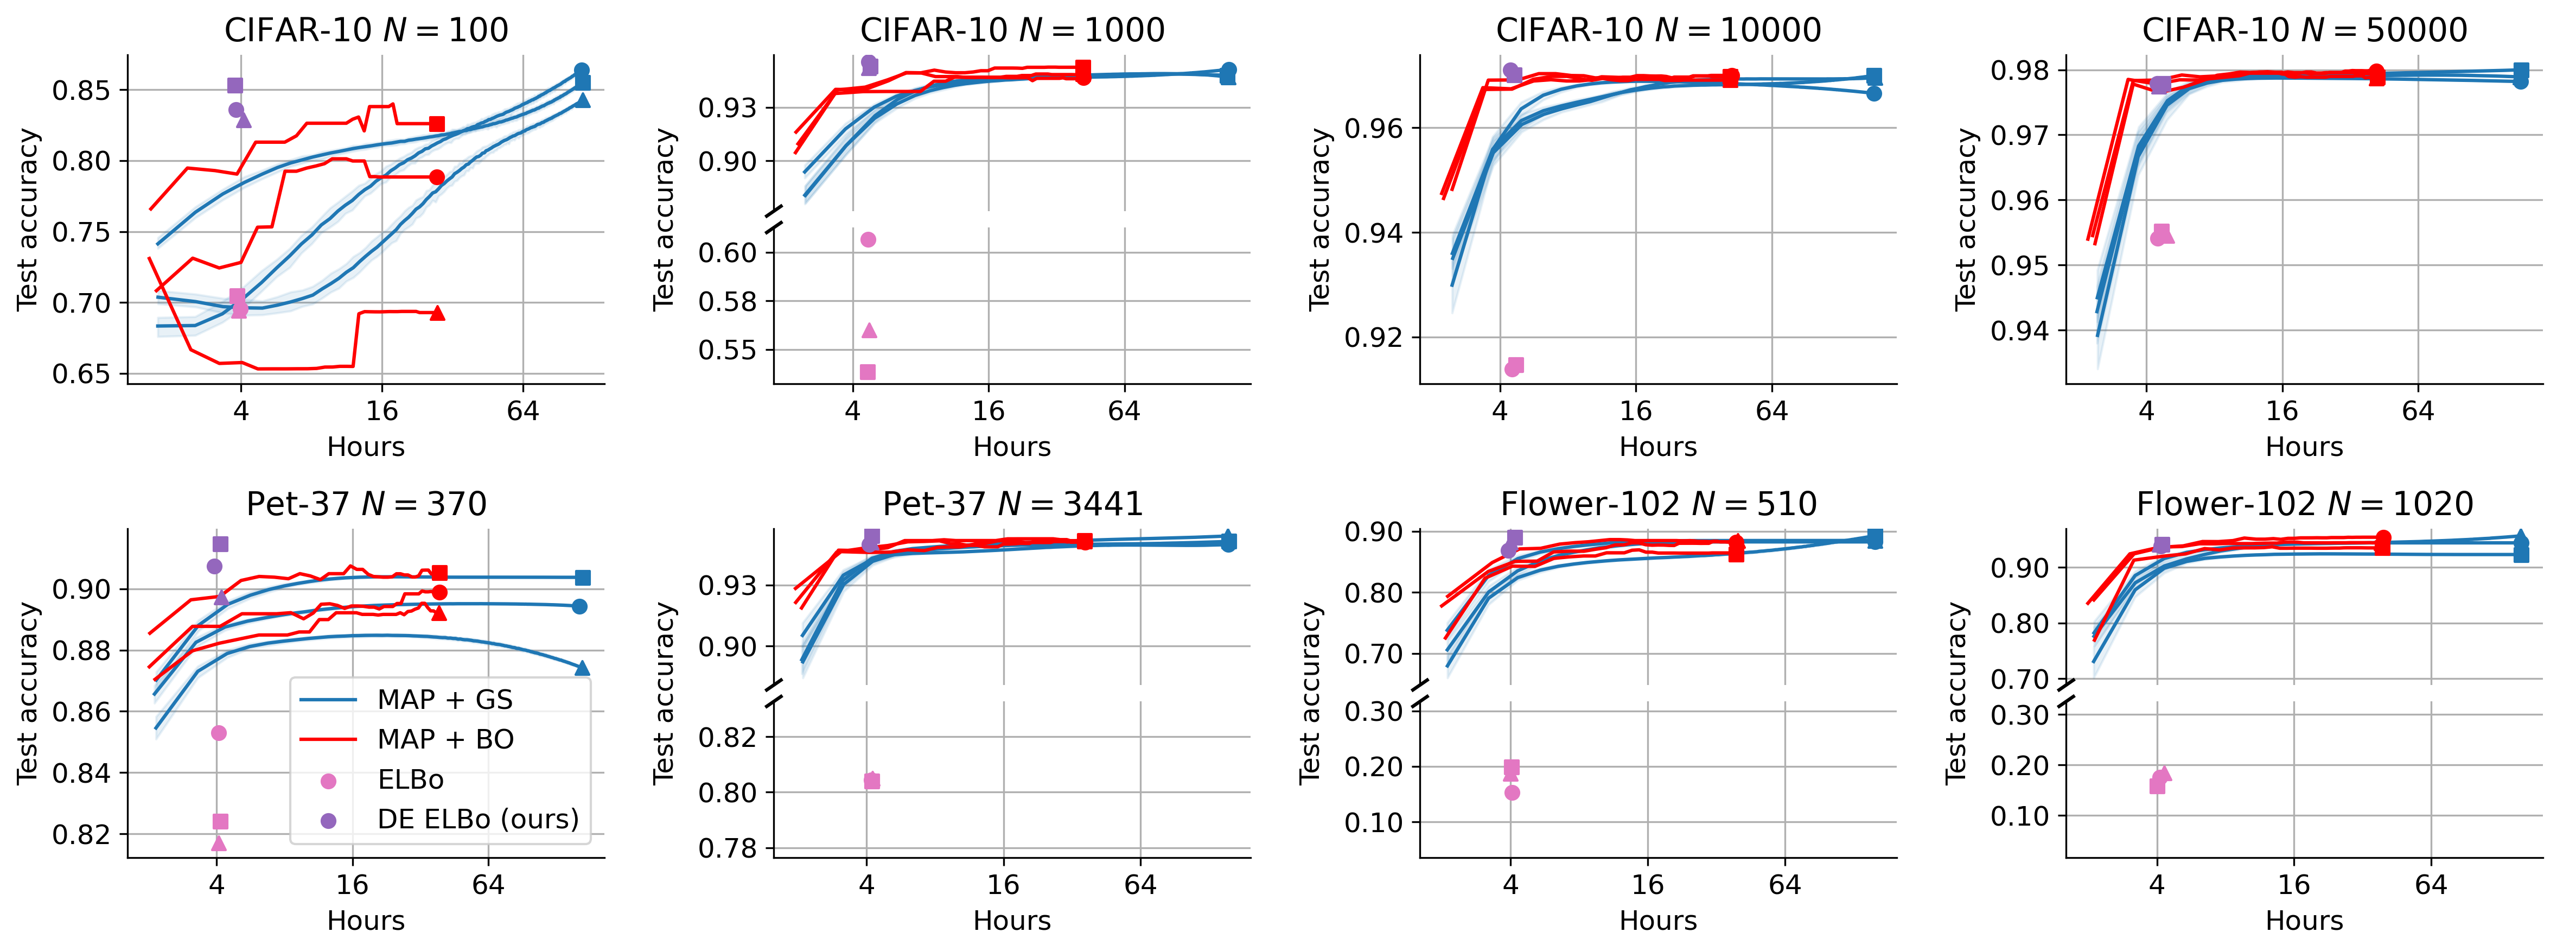

In [18]:
def break_axes(ax):
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (0.525 - d, 0.525 + d), **kwargs)
    ax.plot((-d, +d), (0.475 - d, 0.475 + d), **kwargs)
    
def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xscale('log', base=2)
    ax_xticks = ax.get_xticks()
    ax.set_xticks([int(ax_xtick) for ax_xtick in ax_xticks[2:-2]], [int(ax_xtick) for ax_xtick in ax_xticks[2:-2]])
    ax.grid()
    
def decorate_hidden_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Test accuracy')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax.tick_params(axis='y', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    
def decorate_broken_axes(ax1, ax2):
    
    ax1.spines[['bottom', 'top', 'right']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
        
    ax1.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)
    ax1_xlim = ax1.get_xlim()
    ax1_xticks = ax1.get_xticks()
    ax1.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    ax1.tick_params(axis='x', color=(0, 0, 0, 0), labelcolor=(0, 0, 0, 0), which='both')
    ax2.set_xlim(ax1_xlim)
    ax2.set_xticks([int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]], [int(ax1_xtick) for ax1_xtick in ax1_xticks[2:-2]])
    
    ax1_distance = ax1.get_ylim()[1] - ax1.get_ylim()[0]
    ax2_mean = sum(ax2.get_ylim())/2
    ax2_distance = [max(0.0, ax2_mean - (ax1_distance/2)), max(ax2_mean + (ax1_distance/2) - (ax2_mean - (ax1_distance/2)), ax2_mean + (ax1_distance/2))]
    ax2.scatter(4*np.ones_like(ax2_distance), ax2_distance, color='#FFFFFF')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(ax1.get_yticks()[-1] - ax1.get_yticks()[-2], 3)))
    if len(ax2.get_yticks()) > 5:
        ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    ax1.grid()
    ax2.grid()
    
markers = ['o', '^', 's']
    
ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

# Plot 1
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,0], cifar10_dictionary, 100, [1001, 2001, 3001])

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==100)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    axs[0,0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)

decorate_ax(axs[0,0], r'CIFAR-10 $N=100$')

# Plot 2
decorate_hidden_ax(axs[0,1], r'CIFAR-10 $N=1000$')

ins2_top = axs[0,1].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins2_bottom = axs[0,1].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)

plot_dictionary(ins2_top, cifar10_dictionary, 1000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==1000].test_acc.values)):
    ins2_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==1000].test_acc.values)):
    ins2_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==1000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins2_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    ins2_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)

break_axes(axs[0,1])
decorate_broken_axes(ins2_top, ins2_bottom)

# Plot 3
plot_dictionary(axs[0,2], cifar10_dictionary, 10000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==10000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,2].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    axs[0,2].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)
    
decorate_ax(axs[0,2], r'CIFAR-10 $N=10000$')

# Plot 4
plot_dictionary(axs[0,3], cifar10_dictionary, 50000, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_elbo_retrained_df[cifar10_elbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].total_time.values/3600, cifar10_de_elbo_retrained_df[cifar10_de_elbo_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = cifar10_bo_grouped_df[(cifar10_bo_grouped_df.n==50000)&(cifar10_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[0,3].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    axs[0,3].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)
    
decorate_ax(axs[0,3], r'CIFAR-10 $N=50000$')

# Plot 5
plot_dictionary(axs[1,0], pet37_dictionary, 370, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_de_elbo_retrained_df[pet37_de_elbo_retrained_df.n==370].total_time.values/3600, pet37_de_elbo_retrained_df[pet37_de_elbo_retrained_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==370)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    axs[1,0].scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    axs[1,0].plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)
    
decorate_ax(axs[1,0], r'Pet-37 $N=370$')

# Legend
axs[1,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[1,0].plot([], [], color='red', label='MAP + BO', zorder=3)
axs[1,0].scatter([], [], color='#E377C2', label='ELBo', zorder=3)
axs[1,0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
axs[1,0].legend(loc='lower right')

# Plot 6
decorate_hidden_ax(axs[1,1], r'Pet-37 $N=3441$')

ins6_top = axs[1,1].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins6_bottom = axs[1,1].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)

plot_dictionary(ins6_top, pet37_dictionary, 3441, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].total_time.values/3600, pet37_elbo_retrained_df[pet37_elbo_retrained_df.n==3441].test_acc.values)):
    ins6_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(pet37_de_elbo_retrained_df[pet37_de_elbo_retrained_df.n==3441].total_time.values/3600, pet37_de_elbo_retrained_df[pet37_de_elbo_retrained_df.n==3441].test_acc.values)):
    ins6_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
    
for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = pet37_bo_grouped_df[(pet37_bo_grouped_df.n==3441)&(pet37_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins6_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    ins6_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)
    
break_axes(axs[1,1])
decorate_broken_axes(ins6_top, ins6_bottom)

# Plot 7
decorate_hidden_ax(axs[1,2], r'Flower-102 $N=510$')

ins7_top = axs[1,2].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins7_bottom = axs[1,2].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)

plot_dictionary(ins7_top, flower102_dictionary, 510, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==510].test_acc.values)):
    ins7_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_de_elbo_retrained_df[flower102_de_elbo_retrained_df.n==510].total_time.values/3600, flower102_de_elbo_retrained_df[flower102_de_elbo_retrained_df.n==510].test_acc.values)):
    ins7_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==510)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins7_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    ins7_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)
        
break_axes(axs[1,2])
decorate_broken_axes(ins7_top, ins7_bottom)

# Plot 8
decorate_hidden_ax(axs[1,3], r'Flower-102 $N=1020$')

ins8_top = axs[1,3].inset_axes([0.0, 0.525, 1.0, 0.475], zorder=1)
ins8_bottom = axs[1,3].inset_axes([0.0, 0.0, 1.0, 0.475], zorder=1)

plot_dictionary(ins8_top, flower102_dictionary, 1020, [1001, 2001, 3001])
for index, (time, acc) in enumerate(zip(flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].total_time.values/3600, flower102_elbo_retrained_df[flower102_elbo_retrained_df.n==1020].test_acc.values)):
    ins8_bottom.scatter(time, acc, color='#E377C2', marker=markers[index], zorder=3)
for index, (time, acc) in enumerate(zip(flower102_de_elbo_retrained_df[flower102_de_elbo_retrained_df.n==1020].total_time.values/3600, flower102_de_elbo_retrained_df[flower102_de_elbo_retrained_df.n==1020].test_acc.values)):
    ins8_top.scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)

for index, random_state in enumerate([1001, 2001, 3001]):
    temp_df = flower102_bo_grouped_df[(flower102_bo_grouped_df.n==1020)&(flower102_bo_grouped_df.random_state==random_state)]
    temp_df = temp_df.sort_values('n_iter')
    ins8_top.scatter(temp_df.runtime_mean.values[-1]/3600, temp_df.test_acc_mean.values[-1], color='red', marker=markers[index], zorder=2)
    ins8_top.plot(temp_df.runtime_mean.values/3600, temp_df.test_acc_mean.values, color='red', zorder=2)

break_axes(axs[1,3])
decorate_broken_axes(ins8_top, ins8_bottom)

fig.tight_layout()
fig.savefig('convnext_tiny_computational_time_comparison.pdf', bbox_inches='tight')
plt.show()